We import the various libraries

In [1]:
!pip install pennylane
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt



My Quantum Model to learn the sine function
===========================================
### Discretizing the Interval

In [2]:

# Discretizing the interval [0, 2π]
x_values = np.linspace(0,2 * np.pi, 100) # 100 point as our choice
y_values = np.sin(x_values)  # Labels are the sine values

In [3]:
print(2 * np.pi)

6.283185307179586


### Defining the loss function

In [4]:

np.random.seed(42)

def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss = loss + (t - p) ** 2
    return loss

We define the quantum circuit

In [5]:


dev = qml.device('default.qubit', wires=1)

def State(x):
    qml.RX(x, wires=0) # This functions are responsible for encoding classical data into the quantum state.

def apply_theta(theta):
    qml.Rot(theta[0], theta[1], theta[2], wires=0)

@qml.qnode(dev)
def quantum_model(weights, x=None): #This function represents the quantum model that takes in weights (parameters for the trainable circuit) and an optional input x (data to be encoded).

    for theta in weights[:-1]:
        apply_theta(theta)
        State(x)

    # last set of weights is applied to the qubit
    apply_theta(weights[-1])

    return qml.expval(qml.PauliZ(wires=0))

We plot the original sine function on the data points

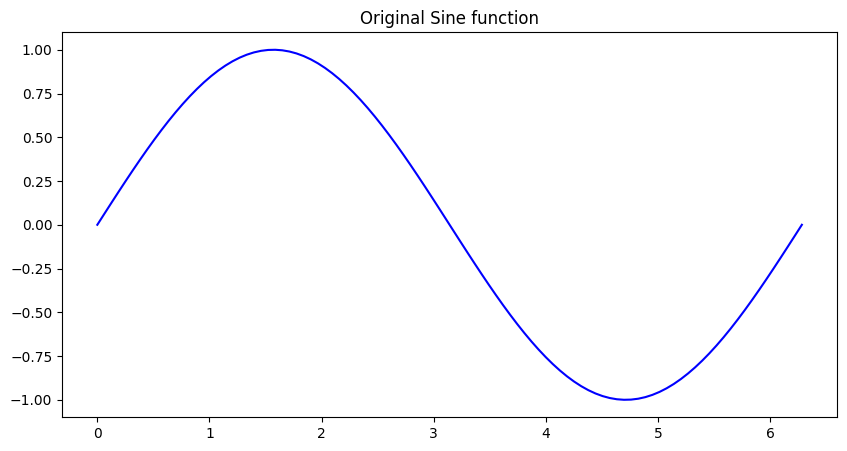

In [6]:

plt.figure(figsize=(10, 5))
plt.plot(x_values, y_values, color='blue')
plt.title('Original Sine function')
plt.show()


### Training the Model

In [7]:
r = 2 # number of times the encoding gets repeated
weights = 2*np.pi*np.random.random(size=(r+1, 3)) # some random initial weights

In [12]:
def cost(weights, x, y):
    predictions = [quantum_model(weights, x=x_) for x_ in x]
    return square_loss(y, predictions)

max_steps = 70
opt = qml.AdamOptimizer(0.5)
batch_size = 5
cst = [cost(weights, x_values, y_values)]  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x_values), (batch_size,))
    x_batch = x_values[batch_index]
    y_batch = y_values[batch_index]

    # Update the weights by one optimizer step
    weights = opt.step(lambda w: cost(w, x_batch, y_batch), weights)

    # Save, and possibly print, the current cost
    c = cost(weights, x_values, y_values)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 27.913038106881274
Cost at step  20: 10.323336698060158
Cost at step  30: 4.324630598128069
Cost at step  40: 6.60671234560385
Cost at step  50: 3.861324123295797
Cost at step  60: 1.4050068072958093
Cost at step  70: 0.08870102458237861


Lets plot the actual and predicted values on the same graph and compair them.

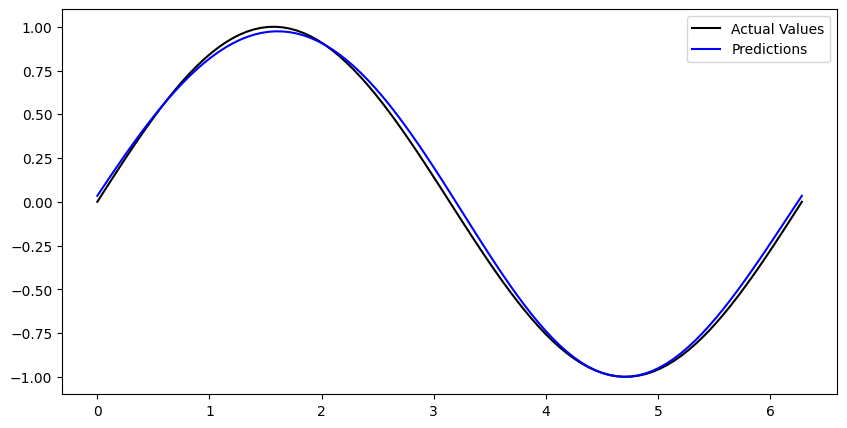

In [13]:
predictions = [quantum_model(weights, x) for x in x_values]
plt.figure(figsize=(10, 5))
plt.plot(x_values, y_values, c='black',label='Actual Values')
plt.plot(x_values, predictions, c='blue',label='Predictions')
plt.legend()

plt.show()


We observe that the Quantum Machine Learning model accurately replicates the values of the sine function.